In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
from torch.func import vmap, grad
from torch.utils.data import DataLoader, TensorDataset

import helper as help

%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div align="center">

### Parameter Selection ###

</div>

In [24]:
# Parameters
d = 17
x0 = np.random.randn(d)
burn_in = 10**5
N = 10**5
dt = .001
T = 8
lambd = 0.03
h = 1 / (1+d)

<div align="center">

### Initial Gibbs Samples ###
Gibbs Samples from Overdamped Langevin Dynamics 
</div>

In [25]:
gibbs_samples = help.overdamped_langevin(x0 = x0, burn_in=burn_in, N=N, dt=dt, T=T, lambd=lambd, h=h)

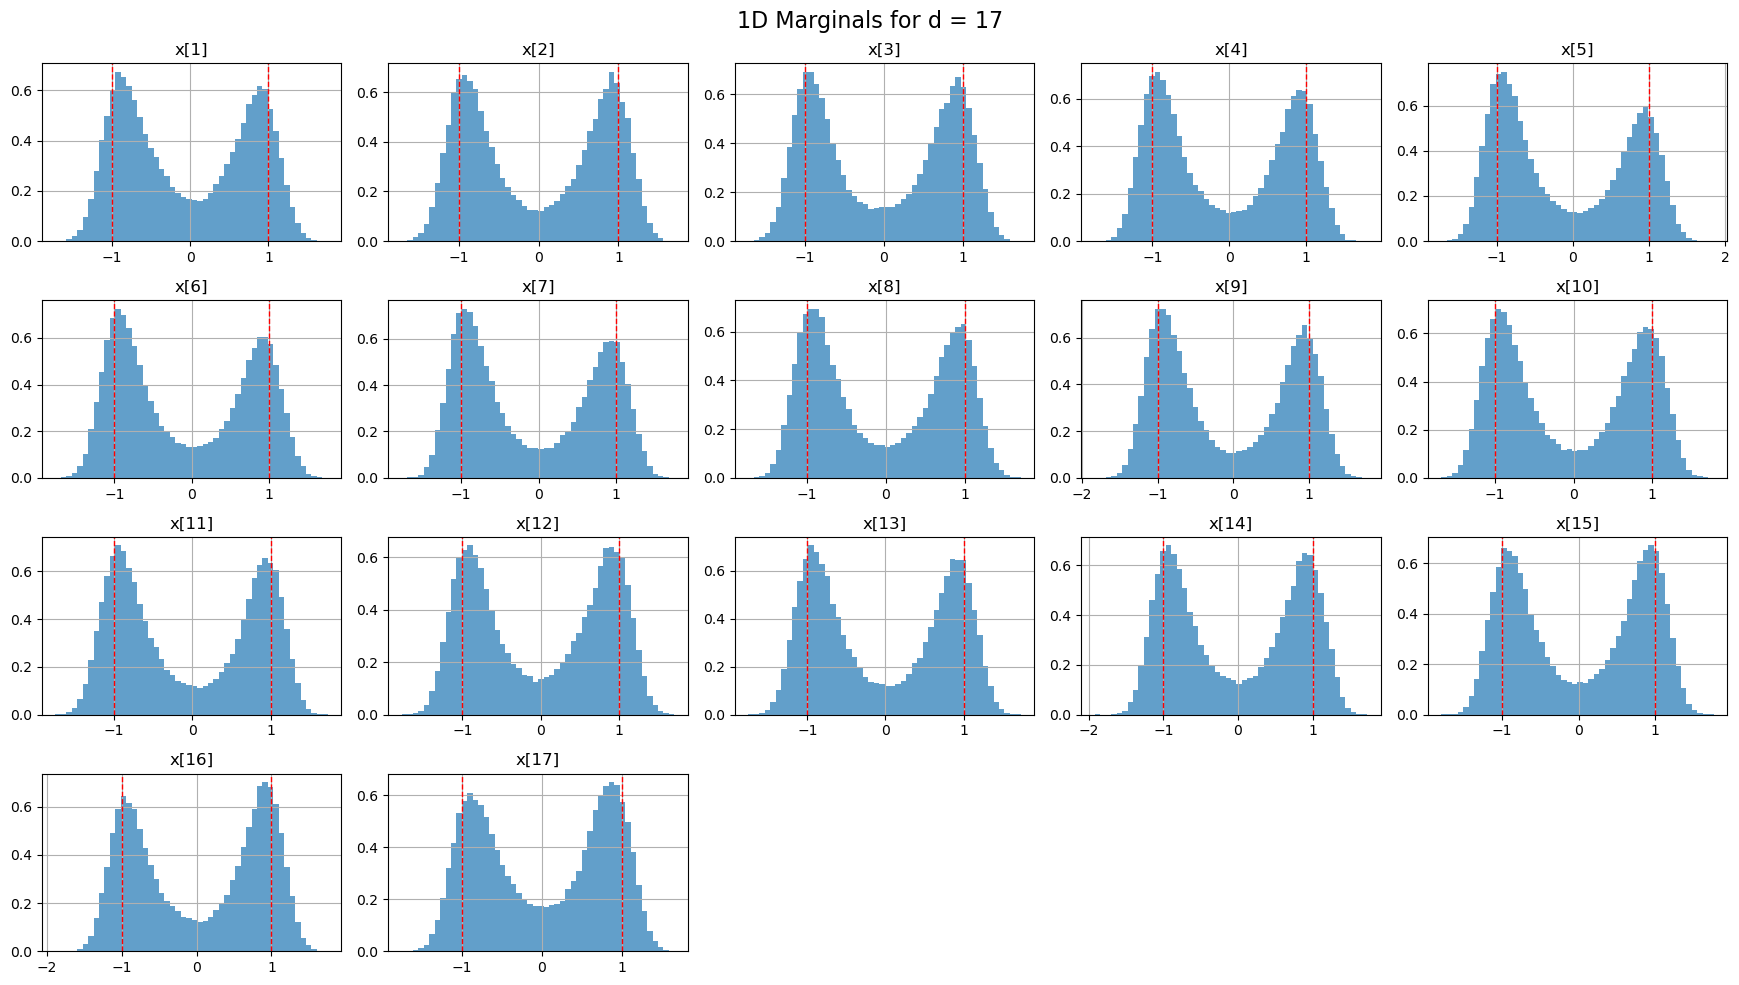

In [26]:
help.visualize_all_1d_marginals(samples=gibbs_samples,d=d)

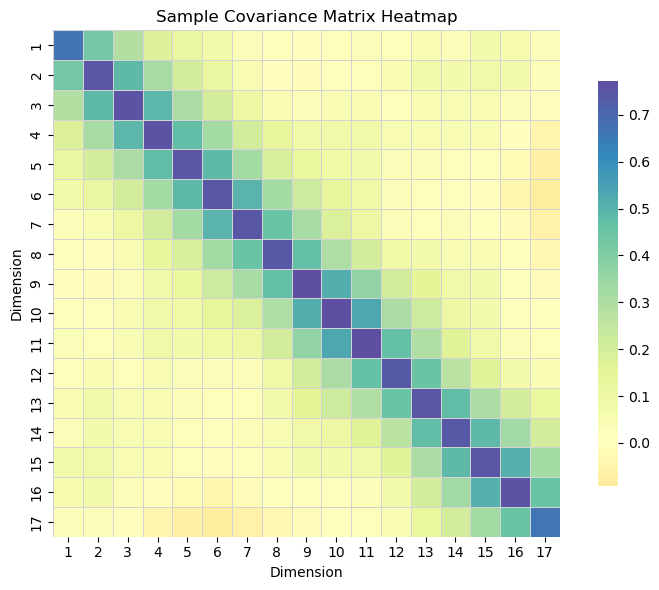

In [27]:
help.plot_cov(samples=gibbs_samples)

<div align="center">

### Neural Network and Training ###

</div>

In [ ]:
class ResidualMLPBlock(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(d, 256),
            nn.SiLU(),
            nn.Linear(256, d)
        )

    def forward(self, x):
        return x + self.block(x)

class ScoreResNetConv(nn.Module):
    def __init__(self, d, n_blocks=3):
        super().__init__()
        self.d = d

        
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),  
            nn.SiLU(),
            nn.Conv1d(16, 1, kernel_size=3, padding=1),  
            nn.SiLU()
        )

        
        self.res_blocks = nn.Sequential(
            *[ResidualMLPBlock(d) for _ in range(n_blocks)]
        )

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.conv(x)    
        x = x.squeeze(1)    
        return self.res_blocks(x)


In [29]:
def train_score_model(model, samples, epochs=20, lr=1e-3, sigma=.3, batch_size=128):
    device = next(model.parameters()).device
    samples = torch.tensor(samples, dtype=torch.float32, device=device)
    dataset = TensorDataset(samples)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    step = 0
    first_loss_printed = False
    final_loss = None

    for epoch in range(epochs):
        for (x,) in dataloader:
            noise = torch.randn_like(x) * sigma
            x_noisy = x + noise
            target = -noise / (sigma**2)
            pred = model(x_noisy)
            loss = ((pred - target)**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if not first_loss_printed:
                print(f"Initial Loss (Epoch {epoch+1}, Step {step}): {loss.item():.4f}")
                first_loss_printed = True

            final_loss = loss.item()
            step += 1

    print(f"Final Loss (Epoch {epochs}, Step {step}): {final_loss:.4f}")
    return model

In [30]:
fc_model = ScoreResNetConv(d)
train_score_model(fc_model, gibbs_samples)
print('Model Training')

Initial Loss (Epoch 1, Step 0): 11.2865
Final Loss (Epoch 20, Step 15640): 6.5970
Model Training


<div align="center">

### Samples from Score ###
Overdamped Langevin Dynamics using the learned Score Function 
</div>

In [31]:
samples = help.overdamped_langevin_score_conv(model = fc_model,burn_in=burn_in,N=N,dt=dt,T=T,d=d) 

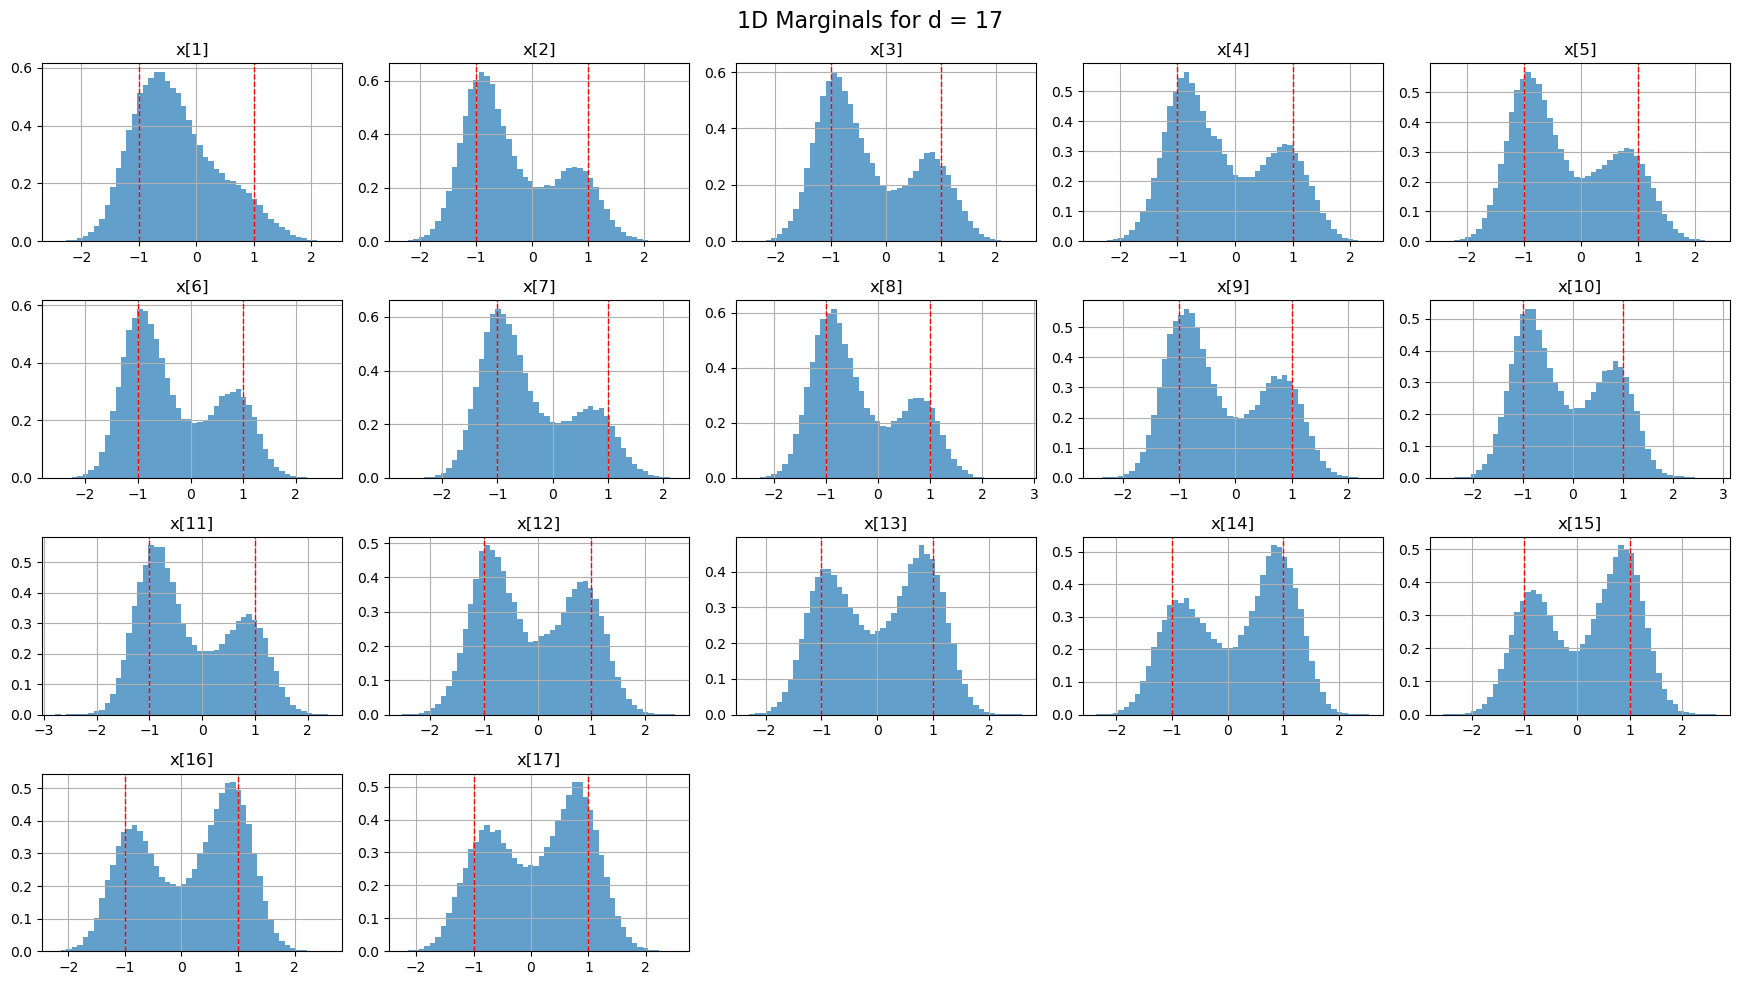

In [32]:
help.visualize_all_1d_marginals(samples=samples,d=d)

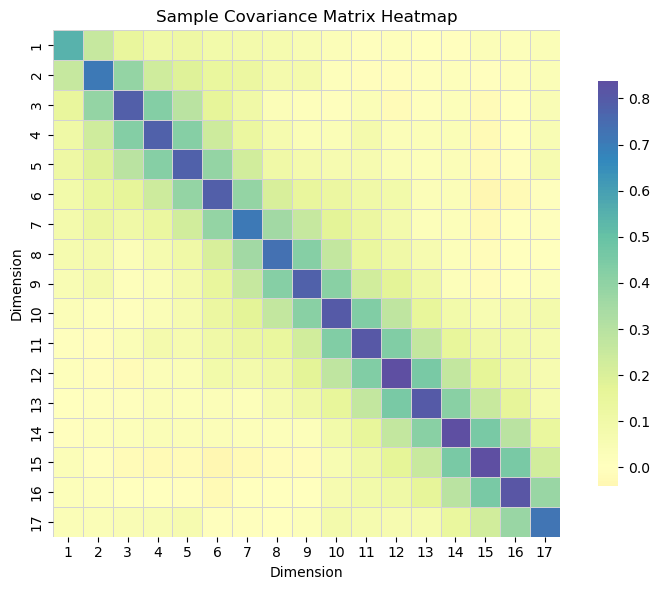

In [33]:
help.plot_cov(samples=samples)

<div align="center">

### Mean Square Error ###

</div>

In [34]:
squared_error = (samples.mean(axis=0) - gibbs_samples.mean(axis=0))**2 
squared_erorr_sum = sum(squared_error)
print(f'Model Square Error is: {squared_erorr_sum}') 

Model Square Error is: 0.6897457657742204


<div align="center">

### Plot Score ###

</div>

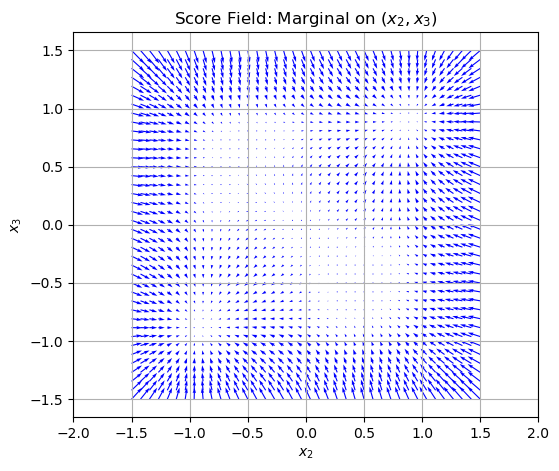

In [42]:
help.plot_score_field(model = fc_model)

<div align="center">

### Principle Component Analysis ###

</div>

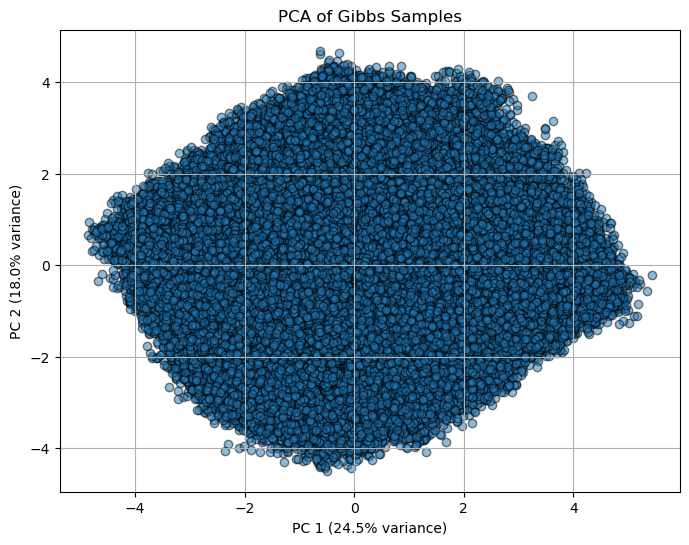

In [52]:
#PCA of Gibbs Samples
scalar = StandardScaler() 
samples_scaled = scalar.fit_transform(gibbs_samples) 

pca = PCA(n_components=2) 
pca_results = pca.fit_transform(samples_scaled) 

plt.figure(figsize=(8, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, edgecolors='k')
plt.title('PCA of Gibbs Samples')
plt.xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True)
plt.show()

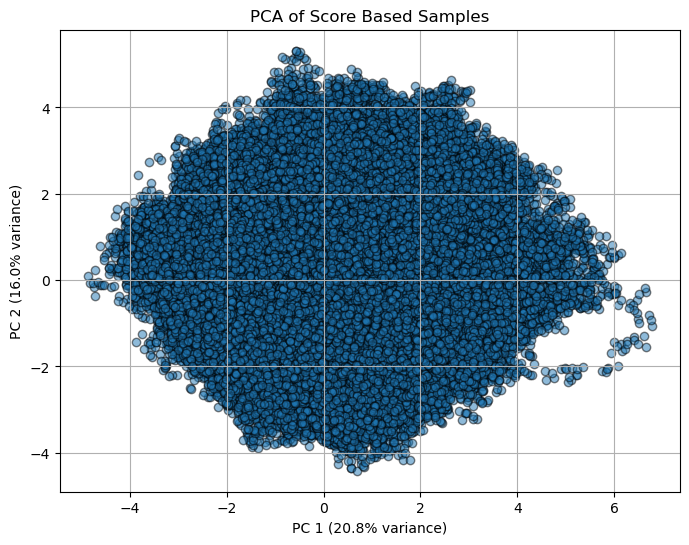

In [53]:
#PCA of Score Based Samples
scalar = StandardScaler() 
samples_scaled = scalar.fit_transform(samples) 

pca = PCA(n_components=2) 
pca_results = pca.fit_transform(samples_scaled) 

plt.figure(figsize=(8, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, edgecolors='k')
plt.title('PCA of Score Based Samples')
plt.xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True)
plt.show()